# 图像分类框架的搭建

### 1. Package Import

In [8]:
# Pytorch 

# application(Image classification)
# Transfer learning

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
# torchtext

import matplotlib.pyplot as plt

In [13]:
import transforms

### 2. 数据预处理与加载

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


# Hyperparameter settings
batch_size = 32
learning_rate = 10e-2 
momentum = 0.5
epoch = 1
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}


#Data Proprecessing and Loading
# MNIST 

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data',train = True, 
                   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.AugmentAndMix(),
                       transforms.RandomErasing(probability = 0.5 , sh = 0.4, r1 =  0.3, mean = [0.4914]),
                       transforms.RandomCrop(28, padding=4),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       transforms.RandomHorizontalFlip()
                   ])
                  
                  
                  ), batch_size = batch_size, shuffle = True, ** kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data',train = False,
                   transform = transforms.Compose([
                       transforms.ToTensor()
                   ])
                  ), batch_size = batch_size, shuffle = True, ** kwargs)



In [16]:
img = next(iter(train_loader))[0][2]
img.shape

torch.Size([1, 28, 28])

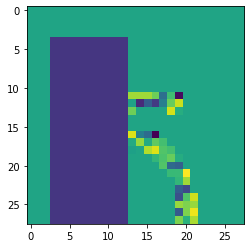

In [17]:
unloader = transforms.ToPILImage()
plt.ion()


def show_img(tensor, title=''):
    image = tensor.clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
plt.figure()
show_img(img)

### 3. 模型定义

In [4]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(800, 500)
        self.fc2 = nn.Linear(500,10)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2 ,2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2 ,2)
        x = x.view(-1, 4* 4 * 50)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return x
    

model = MyNet()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)


### 4. 训练与测试

In [5]:
def train(model, train_loader, optimzer, print_interval = 100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #data, target
        optimizer.zero_grad()
        data = data.float()
        output = model(data)
#         print(data.shape)
#         print(output.shape)
#         print(target.shape)
        loss = F.nll_loss(output,target)
        
        loss.backward()
        optimzer.step()
        
        if batch_idx % print_interval == 0:
            print("Training Epoch: ", epoch,'Batch Id: ', batch_idx, 'Loss: ', loss.item() )
            
            


In [6]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.float()

            output = model(data)
            test_loss = F.nll_loss(output, target, reduction='sum').item()
            

            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            print('prediction: ' ,pred.tolist())
            print('Label: ', target.tolist())
            
    test_loss /= len(test_loader.dataset)
    
    print('Test set average loss: ', test_loss,'Accuracy: ', 100.0 * correct / len(test_loader.dataset) )

In [7]:
for i in range(epoch):
    train(model, train_loader, optimizer)
    test(model, test_loader)

Training Epoch:  1 Batch Id:  0 Loss:  2.299804449081421
Training Epoch:  1 Batch Id:  100 Loss:  1.350174903869629
Training Epoch:  1 Batch Id:  200 Loss:  1.6611500978469849
Training Epoch:  1 Batch Id:  300 Loss:  0.6686004996299744
Training Epoch:  1 Batch Id:  400 Loss:  0.9169970154762268
Training Epoch:  1 Batch Id:  500 Loss:  0.6723814606666565
Training Epoch:  1 Batch Id:  600 Loss:  0.8735993504524231
Training Epoch:  1 Batch Id:  700 Loss:  0.48735347390174866
Training Epoch:  1 Batch Id:  800 Loss:  0.5358002185821533
Training Epoch:  1 Batch Id:  900 Loss:  0.29734164476394653
Training Epoch:  1 Batch Id:  1000 Loss:  0.3701770305633545
Training Epoch:  1 Batch Id:  1100 Loss:  0.9882599115371704
Training Epoch:  1 Batch Id:  1200 Loss:  0.6526018977165222
Training Epoch:  1 Batch Id:  1300 Loss:  0.938273012638092
Training Epoch:  1 Batch Id:  1400 Loss:  0.7239750623703003
Training Epoch:  1 Batch Id:  1500 Loss:  0.7170748114585876
Training Epoch:  1 Batch Id:  1600 Lo

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [4, 2, 9, 3, 5, 6, 0, 1, 5, 1, 0, 3, 2, 3, 4, 1, 1, 1, 4, 6, 1, 0, 5, 6, 7, 6, 7, 7, 9, 5, 5, 4]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [4, 0, 1, 2, 9, 7, 4, 9, 7, 5, 0, 3, 8, 1, 1, 9, 0, 1, 5, 8, 3, 3, 8, 0, 5, 9, 9, 5, 4, 4, 6, 5]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [1, 6, 0, 0, 7, 2, 3, 8, 8, 9, 1, 7, 9, 3, 2, 7, 9, 2, 7, 8, 4, 7, 9, 7, 5, 2, 2, 7, 6, 7, 7, 6]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [9, 5, 3, 1, 5, 3, 4, 0, 3, 1, 1, 1, 1, 6, 0, 9, 8, 8, 5, 8, 7, 6, 0, 0, 0, 7, 1, 7, 4, 0, 1, 7]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [1, 7, 7, 0, 5, 0, 1, 3, 1, 0, 1, 3, 6, 9, 2, 6, 9, 0, 3, 0, 9, 5, 2, 7, 9, 9, 1, 3, 9, 5, 4, 2]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [1, 0, 4, 2, 4, 4, 1, 9, 5, 3, 9, 2, 1, 7, 9, 1, 6, 3, 8, 5, 1, 5, 0, 8, 0, 7, 4, 7, 4, 2, 4, 4]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [7, 0, 4, 2, 6, 6, 6, 5, 2, 8, 5, 4, 2, 7, 9, 2, 8, 1, 2, 8, 0, 8, 3, 7, 7, 6, 2, 6, 8, 6, 9, 7]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [5, 7, 4, 9, 7, 6, 5, 0, 5, 5, 3, 8, 3, 7, 1, 3, 4, 0, 8, 8, 9, 7, 5, 2, 0, 3, 1, 4, 3, 1, 0, 7]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [1, 1, 3, 1, 2, 3, 2, 2, 0, 1, 9, 1, 9, 1, 3, 5, 3, 4, 2, 1, 9, 1, 3, 9, 7, 2, 2, 1, 7, 3, 1, 3]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [2, 2, 5, 4, 3, 0, 2, 9, 0, 0, 9, 8, 7, 8, 0, 9, 4, 2, 3, 7, 2, 1, 4, 1, 8, 3, 8, 1, 9, 5, 9, 4]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [5, 7, 2, 3, 5, 3, 7, 1, 8, 4, 0, 8, 9, 5, 4, 5, 7, 7, 1, 0, 2, 4, 3, 5, 6, 0, 9, 9, 8, 6, 7, 0]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [4, 1, 1, 3, 7, 3, 8, 7, 7, 0, 3, 2, 2, 9, 5, 2, 6, 5, 3, 5, 7, 5, 9, 5, 8, 2, 9, 2, 9, 2, 6, 0]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [3, 4, 7, 6, 3, 7, 1, 5, 3, 2, 4, 3, 5, 0, 0, 2, 2, 3, 6, 0, 4, 8, 1, 1, 6, 9, 9, 6, 2, 3, 8, 4]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [5, 9, 3, 8, 7, 3, 3, 9, 3, 3, 7, 4, 5, 8, 5, 1, 1, 9, 2, 1, 1, 3, 3, 6, 2, 7, 1, 4, 3, 5, 0, 4]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [4, 3, 0, 6, 7, 5, 0, 4, 1, 3, 7, 4, 4, 3, 4, 7, 7, 7, 5, 0, 2, 4, 4, 2, 6, 4, 4, 1, 8, 9, 8, 4]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [8, 8, 3, 5, 0, 7, 9, 4, 2, 2, 9, 7, 4, 4, 4, 3, 7, 1, 0, 0, 6, 4, 3, 1, 9, 7, 9, 7, 9, 9, 1, 2]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [4, 6, 9, 9, 7, 4, 9, 4, 5, 8, 0, 0, 2, 0, 2, 9, 9, 7, 8, 1, 9, 7, 0, 2, 3, 1, 4, 9, 5, 8, 8, 0]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [8, 1, 7, 1, 0, 8, 9, 9, 3, 8, 9, 5, 8, 5, 0, 3, 2, 9, 8, 4, 8, 6, 1, 5, 8, 6, 5, 7, 9, 6, 8, 9]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [1, 0, 0, 9, 9, 4, 5, 1, 3, 7, 7, 3, 5, 9, 3, 1, 2, 6, 1, 2, 4, 7, 3, 5, 8, 6, 8, 9, 8, 5, 1, 2]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [8, 8, 4, 7, 8, 1, 6, 2, 8, 3, 1, 3, 0, 5, 5, 9, 9, 3, 1, 4, 4, 4, 3, 0, 0, 8, 3, 7, 8, 8, 0, 1]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [7, 0, 1, 6, 9, 9, 2, 6, 7, 4, 9, 2, 7, 2, 5, 0, 9, 5, 4, 6, 3, 1, 1, 3, 0, 1, 8, 8, 4, 1, 0, 2]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [6, 8, 3, 5, 0, 2, 2, 0, 3, 3, 4, 4, 6, 2, 9, 1, 0, 6, 2, 8, 7, 2, 4, 6, 1, 5, 0, 1, 9, 6, 5, 7]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [0, 7, 7, 1, 0, 8, 2, 9, 2, 0, 2, 5, 0, 4, 0, 0, 3, 6, 3, 6, 4, 5, 3, 9, 0, 0, 8, 3, 4, 3, 0, 2]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [5, 9, 6, 9, 8, 2, 8, 3, 4, 9, 1, 7, 8, 9, 3, 1, 7, 9, 6, 5, 7, 3, 9, 4, 4, 1, 0, 4, 0, 4, 4, 8]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [0, 0, 8, 1, 9, 3, 1, 7, 7, 3, 5, 9, 9, 2, 0, 4, 0, 3, 5, 3, 5, 9, 1, 1, 2, 0, 5, 7, 9, 5, 6, 3]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [4, 6, 1, 8, 7, 9, 0, 8, 4, 4, 3, 0, 8, 5, 8, 8, 7, 7, 3, 3, 5, 8, 9, 1, 2, 2, 6, 7, 6, 5, 4, 6]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
Label:  [0, 0, 4, 8, 7, 1, 1, 4, 0, 4, 7, 1, 5, 7, 5, 6, 8, 2, 3, 1, 5, 5, 3, 7, 6, 6, 0, 9, 3, 6, 8, 4]
prediction:  [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

### 迁移学习

训练一个新的图像分类的任务，但是并不是learn from scratch， 我们利用一个训练好的模型，在新的训练数据上再进行训练，从而加速模型的学习速率和学习效果。而使用的最开始的模型我们称为预训练模型

- Fashion Minist dataset
- ImageNet

一般迁移学习有两种方式：

- Fine-tuning: 微调模型结构，去更好地适用新的数据 
- Feature extraction：把我们预训练模型作为一个特征抽取器，利用抽取出来的特征重构新的模型来进行训练

In [7]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn 

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)
import transforms
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Torchvision Version:  0.9.1


### 训练

In [2]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)
        
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else: 
                model.eval()
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
       
            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
            
        print()
    
    time_elapsed = time.time() - since
    print("Training compete in {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### 迁移学习：使用预训练模型

In [4]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    return model_ft, input_size
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# print(model_ft)

#### 图片可视化

In [9]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True)

In [10]:
img = next(iter(loader))[0]


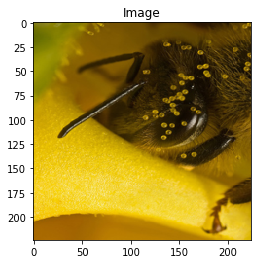

In [11]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[31], title='Image')

## 数据增强

In [15]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.AugmentAndMix(),

        transforms.RandomErasing(probability = 0.5 , sh = 0.4, r1 =  0.3, mean = [0.4914]),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.AugmentAndMix(),
        transforms.RandomErasing(probability = 0.5 , sh = 0.4, r1 =  0.3, mean = [0.4914]),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [16]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, ohist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [ ]:
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

## 可视化实验结果

In [ ]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# ohist = []
# shist = []

# ohist = [h.cpu().numpy() for h in ohist]
# shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()